# Import

In [59]:
import glob
import os

import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Input Data

In [4]:
def read_image_array(image_path):
    im = Image.open(image_path).convert('L')
    im_data = np.asarray(im).ravel()
    im_data = im_data
    return im_data

def read_image_list(image_path):
    im = Image.open(image_path).convert('L')
    im_data = list(im.getdata())
    return im_data

def plot_image(image_array):
    plt.figure()
    plt.imshow(image_array.reshape(256, -1), cmap=plt.get_cmap('gray'))

In [82]:
pixels = 256 * 256
data_limit = 4000

In [83]:
label_train_data = pd.read_csv(os.getcwd() + '\\..\\data\\train.csv', index_col='id')
label_test_data = pd.read_csv(os.getcwd() + '\\..\\data\\test.csv', index_col='id')

In [84]:
image_train_file_list = glob.glob(os.getcwd() + '\\..\\data\\train\\' + "*.jpg")
image_train_data = []
for index, image_path in enumerate(image_train_file_list):
    image_name = image_path.split('\\')[-1]
    data = [image_path.split('\\')[-1]] + read_image_list(image_path) + [label_train_data.loc[image_name.split('.')[0]]['landmark_id']]
    image_train_data.append(data)

    if (data_limit > 0 or data_limit is not False) and index + 1 >= data_limit:
        break

image_test_file_list = glob.glob(os.getcwd() + '\\..\\data\\test\\' + "*.jpg")
image_test_data = []
for index, image_path in enumerate(image_test_file_list):
    image_name = image_path.split('\\')[-1]
    data = [image_path.split('\\')[-1]] + read_image_list(image_path)
    image_test_data.append(data)

    if (data_limit > 0 or data_limit is not False) and index + 1 >= data_limit:
        break

In [85]:
column_names = ['filename'] + ['X%s' % i for i in range(1, pixels + 1)] + ['landmark_id']

image_train_data = pd.DataFrame(data=image_train_data, columns=column_names)
image_train_data.set_index('filename')
image_test_data = pd.DataFrame(data=image_test_data, columns=column_names[:-1])
image_test_data.set_index('filename')

print(image_train_data.shape)
print(image_test_data.shape)

(4000, 65538)
(149, 65537)


In [99]:
# X_train, X_test, y_train, y_test = train_test_split(image_train_data[['X%s' % i for i in range(1, pixels + 1)]].values,
#                                                     image_train_data['landmark_id'].values)

X_train = image_train_data[['X%s' % i for i in range(1, pixels + 1)]].values
y_train = image_train_data['landmark_id'].values

# Preprocessing

In [87]:
numerical_pipeline = Pipeline([
    ('std_scaler', preprocessing.StandardScaler())
])

preprocess_machine = FeatureUnion(transformer_list=[
    ('numerical_pipeline', numerical_pipeline)
])

In [100]:
X_train = preprocess_machine.fit_transform(X_train)
X_test = preprocess_machine.fit_transform(X_test)

# PCA

In [106]:
pca = PCA(n_components=10)
X_r = pca.fit(X_train).transform(X_train)

(4000, 10)


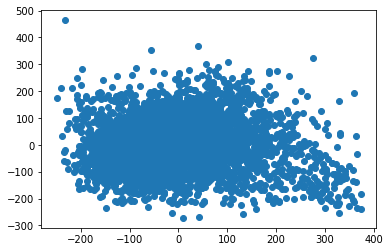

In [107]:
print(X_r.shape)

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1])
plt.show()

In [108]:
data = [
    go.Scatter3d(
        x=X_r[:, 0],
        y=X_r[:, 1],
        z=X_r[:, 2],
        mode='markers',
        marker=dict(
            size=2
        ))
]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)
py.plot(fig)

'file://C:\\Users\\yosef\\Desktop\\Project\\DM_pro_local\\scratch\\temp-plot.html'